# under construction


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
%load_ext autoreload
%autoreload 2

<h2>The "STEERABLE PYRAMID"</h2>

*The steerable pyramid transform given below is described in:
E P Simoncelli and W T Freeman.  
The Steerable Pyramid: A Flexible Architecture for Multi-Scale 
Derivative Computation.  
IEEE Second Int'l Conf on Image Processing.  
Washington DC,  October 1995.  
Online access:  
http://www.cns.nyu.edu/pub/eero/simoncelli95b.pdf*


The steerable pyramid is a multi-scale representation that is
**translation-invariant**, but that also includes representation of
**orientation**.  Furthermore, the representation of orientation is
designed to be rotation-invariant. The basis/projection functions
are oriented (steerable) filters, localized in space and frequency.
**It is overcomplete to avoid aliasing**.  And it is "self-inverting"
(like the QMF/Wavelet transform): the projection functions and 
basis functions are identical.  The mathematical phrase for a 
transform obeying this property is "tight frame".

The system diagram for the steerable pyramid (described in the
reference given below) is as follows:<pre>
 IM ---> fhi0 -----------------> H0 ---------------- fhi0 ---> RESULT
     |                                                     |
     |                                                     |
     |-> flo0 ---> fl1/down2 --> L1 --> up2/fl1 ---> flo0 -|
               |                                 |
               |----> fb0 -----> B0 ----> fb0 ---|
               |                                 |
               |----> fb1 -----> B1 ----> fb1 ---|
               .                                 .
               .                                 .
               |----> fbK -----> BK ----> fbK ---|
</pre>
The filters {fhi0,flo0} are used to initially split the image into
a highpass residual band H0 and a lowpass subband.  This lowpass
band is then split into a low(er)pass band L1 and K+1 oriented
subbands {B0,B1,...,BK}.  The representatation is substantially
overcomplete.  The pyramid is built by recursively splitting the
lowpass band (L1) using the inner portion of the diagram (i.e.,
using the filters {fl1,fb0,fb1,...,fbK}).  The resulting transform is
overcomplete by a factor of 4k/3.

The scale tuning of the filters is constrained by the recursive
system diagram.  The orientation tuning is constrained by requiring
the property of steerability.  A set of filters form a steerable
basis if they 1) are rotated copies of each other, and 2) a copy of
the filter at any orientation may be computed as a linear
combination of the basis filters.  The simplest examples of
steerable filters is a set of N+1 Nth-order directional
derivatives.

**Spatial Domain**

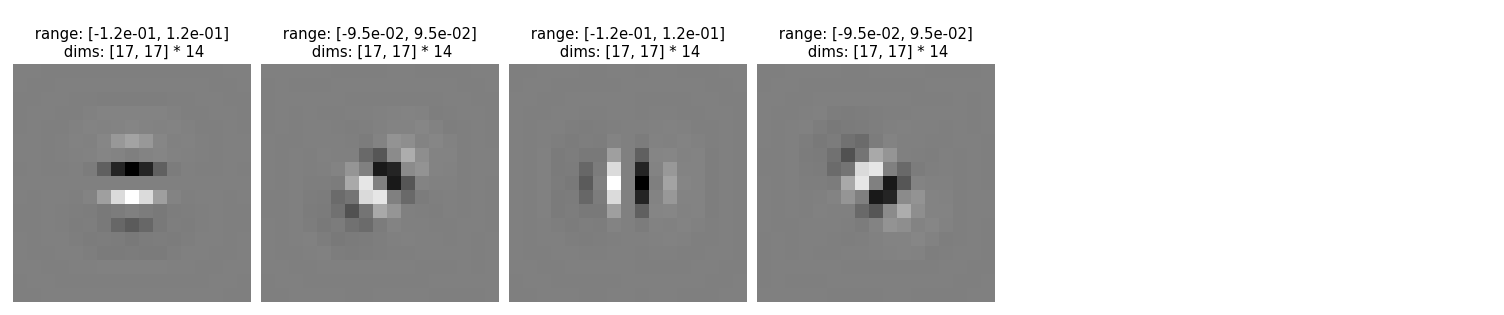

In [2]:
# Choose a filter set (options are 'sp0_filters', 'sp1_filters', 'sp3_filters', 'sp5_filters'):
filters = pt.steerable_filters('sp3_filters')

fsz = int(np.round(np.sqrt(filters['bfilts'].shape[0])))
fsz = np.array([fsz, fsz])
nfilts = filters['bfilts'].shape[1]
nrows = int(np.floor(np.sqrt(nfilts)))

import scipy.signal as sps
# Look at the oriented bandpass filters:
filtList = []
for f in range(nfilts):
    filtList.append(sps.convolve2d(filters['bfilts'][:,f].reshape(fsz), filters['lo0filt']))

pt.imshow(filtList, vrange='auto', zoom=14, col_wrap=6);

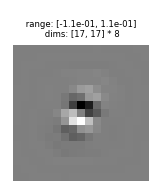

In [3]:
# Try "steering" to a new orientation (new_ori in degrees):
new_ori = 22

# new_ori = 360*np.random.rand(1)[0]
pt.imshow( sps.convolve2d( pt.pyramids.steer(filters['bfilts'],
                                      new_ori * np.pi/180).reshape(fsz),
                           filters['lo0filt']), 'auto', zoom=8);

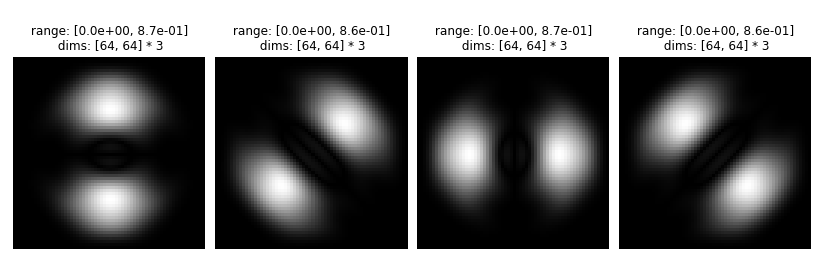

In [4]:
# Look at Fourier transform magnitudes:
lo0filt = filters['lo0filt']
bfilts = filters['bfilts']
lo0 = np.fft.fftshift(np.abs(np.fft.fft2(filters['lo0filt'],(64,64))))
fsum = np.zeros(lo0.shape)
imgList = []
for f in range(bfilts.shape[1]):
    flt = bfilts[:,f].reshape(fsz)
    freq = lo0 * np.fft.fftshift(np.abs(np.fft.fft2(flt,(64,64))))
    fsum += freq**2
    imgList.append(freq)

pt.imshow(imgList, 'auto', zoom=3, col_wrap= 4);

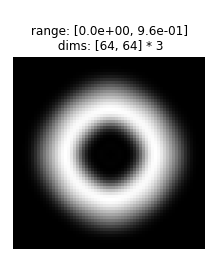

In [5]:
# The filters sum to a smooth annular ring:
pt.imshow(fsum, 'auto', 3);

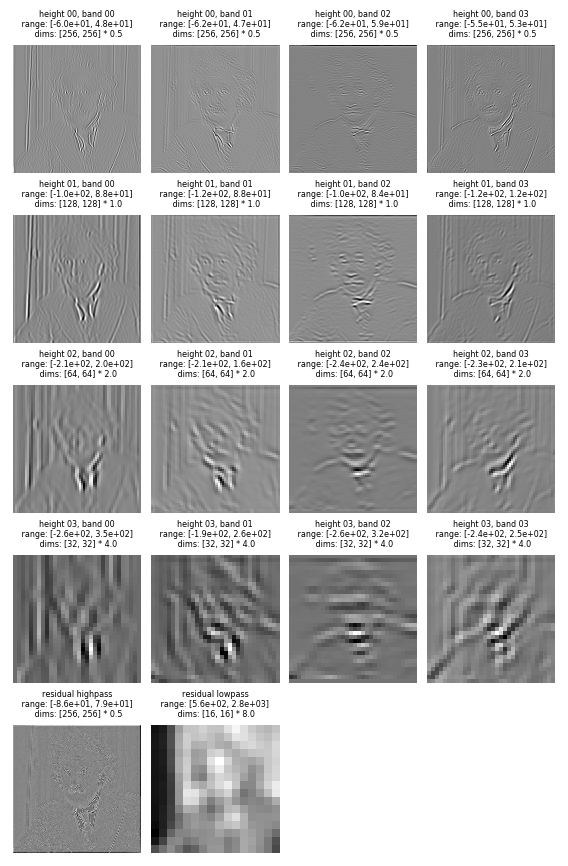

In [6]:
# Now on an image
im = plt.imread('../DATA/einsteinCorrect.pgm')
# im = pt.blurDn(im, 1, 'qmf9')
# pt.imshow(im);

filt = 'sp3_filters' # There are 4 orientations for this filter
pyr = pt.pyramids.SteerablePyramidSpace(im, height=4, num_orientations=4)
pt.pyrshow(pyr, zoom=.5);

In [7]:
# # Look at first (vertical) bands, different scales:
# imgList = []
# for s in range(pyr.spyrHt()):
#     band = pyr.spyrBand(s,0)
#     imgList.append(band)
# pt.imshow(imgList, col_wrap=4);

# # look at all orientation bands at one level (scale):
# imgList = []
# for b in range(pyr.numBands()):
#     band = pyr.spyrBand(1,b)
#     imgList.append(band)

# pt.imshow(imgList, zoom=2, col_wrap=4);

# # look at one oriented band at one level (scale):
# pt.imshow(pyr.spyrBand(lev=2,band=1), 'auto', zoom=4);

# # To access the high-pass and low-pass bands:
# low = pyr.pyrLow()
# high = pyr.pyrHigh()
# pt.imshow([low, high]);

# # Display the whole pyramid (except for the highpass residual band),
# # with images shown at proper relative sizes:
# pyr.showPyr()

In [8]:
# Spin a level of the pyramid, interpolating (steering to)
# intermediate orienations:
lev = np.array([pyr.pyr_coeffs[(1, i)] for i in range(pyr.num_orientations)]) # pick a scale
n = lev[0].shape[0] * lev[0].shape[1]
# create a matrix containing outputs of the pyramid in long columns
lev2 = np.concatenate((lev[0].reshape((n,1)),
                       lev[1].reshape((n,1)),
                       lev[2].reshape((n,1)),
                       lev[3].reshape((n,1))),
                      axis=1)
# lev.shape, lev2.shape

In [9]:
filters = pt.steerable_filters(filt)

k = 32
M = np.empty((k, lev.shape[1], lev.shape[2]))

for frame in range(k):
    steered_im = pt.pyramids.steer(lev2, 2*np.pi*frame/16, filters['harmonics'], filters['mtx']).reshape((128,128))
    M[frame] = steered_im

In [10]:
pt.animshow(M, 1/10)

Difference statistics:
  Range: [-254, -19]
  Mean: -117.163779,  Stdev (rmse): 37.560320,  SNR (dB): -47.605999


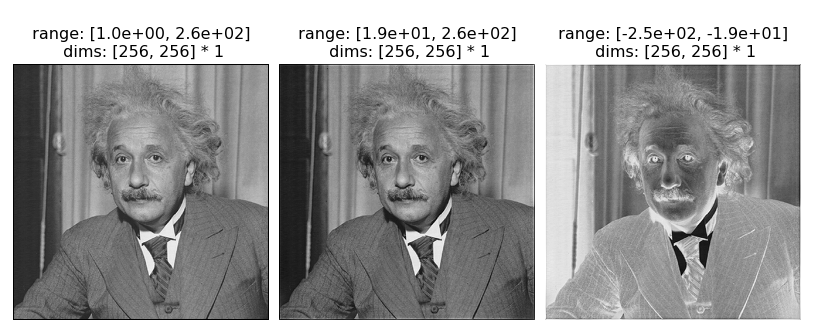

In [11]:
# Reconstruct.  Note that the filters are not perfect, although they are good
# enough for most applications.
res = pyr.recon_pyr()
# pt.imshow([im, res]);
pt.image_compare(im/255,res)

# Note that the difference lie along the boundaries
pt.imshow([im, res, im/255 - res]);

As with previous pyramids, you can select subsets of the levels
and orientation bands to be included in the reconstruction.  For example:

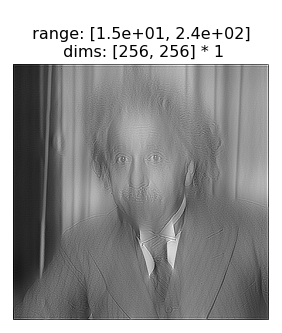

In [12]:
# All levels (including highpass and lowpass residuals), one orientation:
pt.imshow(pyr.recon_pyr(levels='all', bands=[0]));

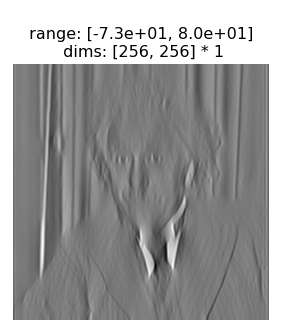

In [13]:
# Without the highpass and lowpass:
pt.imshow(pyr.recon_pyr(levels=range(pyr.num_scales), bands=[0]));

**Frequency domain**

We also provide an implementation of the Steerable pyramid in the
Frequency domain.  The advantages are perfect-reconstruction
(within floating-point error), and any number of orientation
bands.  The disadvantages are that it is typically slower, and the
boundary handling is always circular.

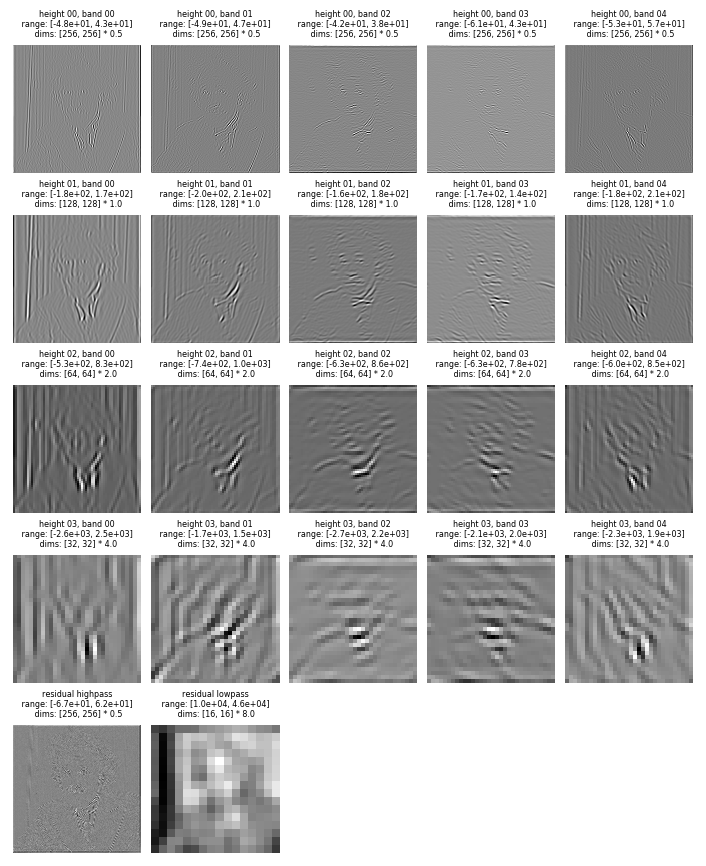

In [14]:
pyr = pt.pyramids.SteerablePyramidFreq(im, height=4, num_orientations=5)    # 4 levels, 5 orientation bands
pt.pyrshow(pyr, zoom=.5);

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000264,  SNR (dB): 103.578358


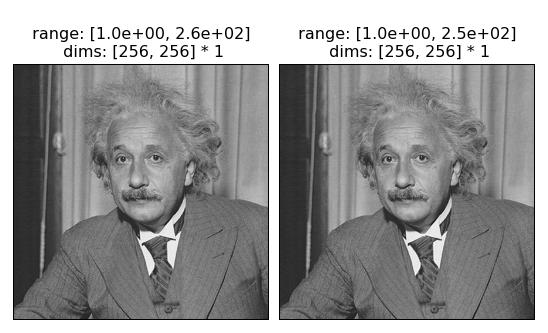

In [15]:
res = pyr.recon_pyr()
pt.image_compare(im,res);  # nearly perfect

pt.imshow([im, res]);

** Complex valued Steerable Pyramid**

*as described in:  
A parametric texture model based on joint statistics of complex wavelet coefficients  
J Portilla and E P Simoncelli.  
Int'l Journal of Computer Vision, vol.40(1), pp. 49--71, Dec 2000  
http://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf*

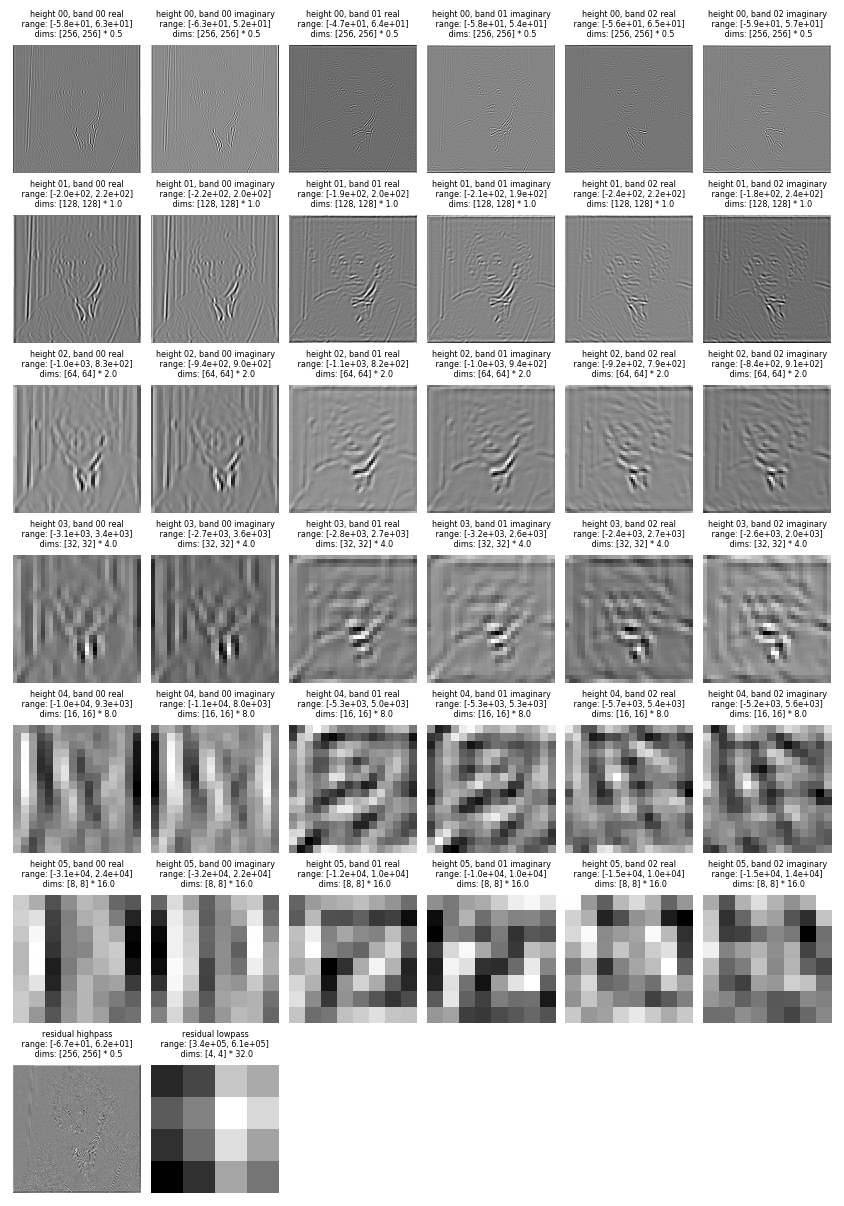

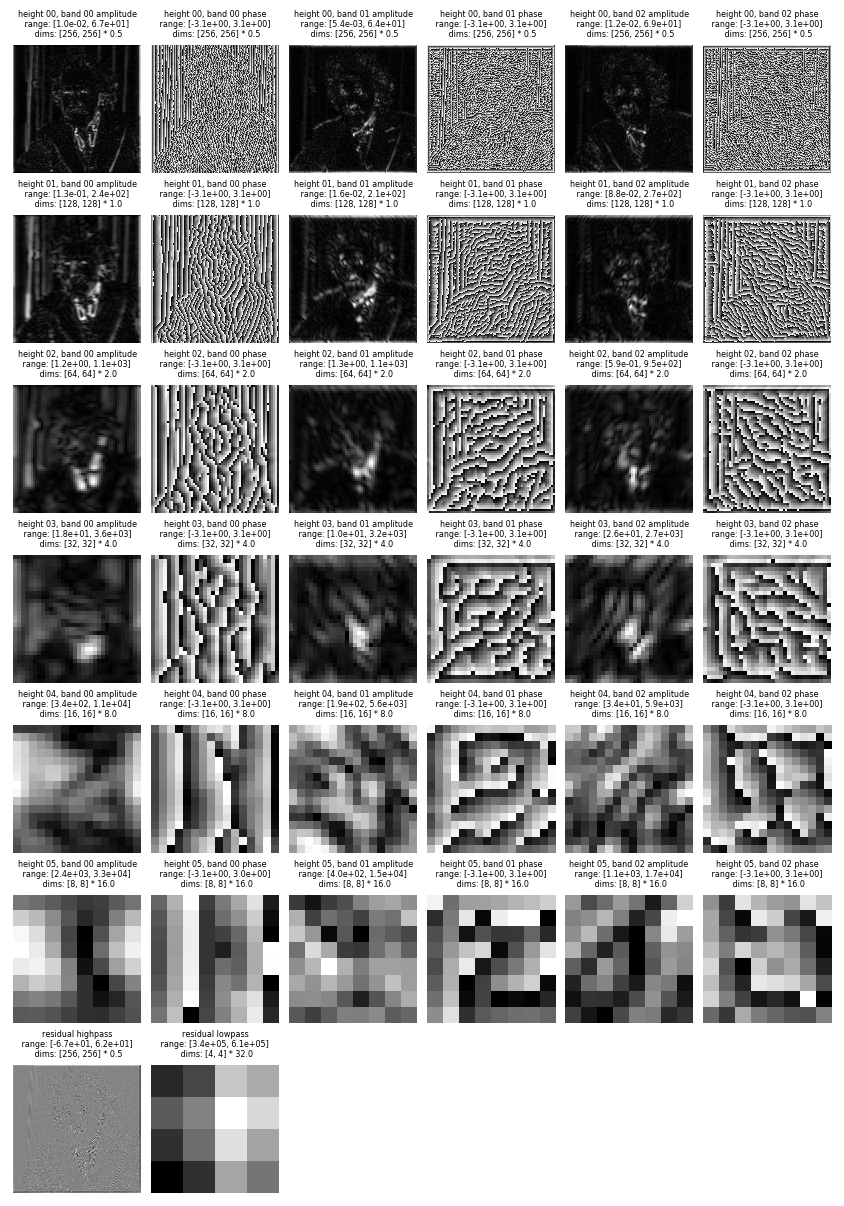

In [16]:
pyr = pt.pyramids.SteerablePyramidFreq(im, num_orientations=3, is_complex=True)
# twice as many orientations
pt.pyrshow(pyr, zoom=.5)

# coordinate transform
pt.pyrshow(pyr, plot_complex='polar', zoom=.5);

### Further demonstrations of steerability


TODO 

In [17]:
# Spatial domain steerability

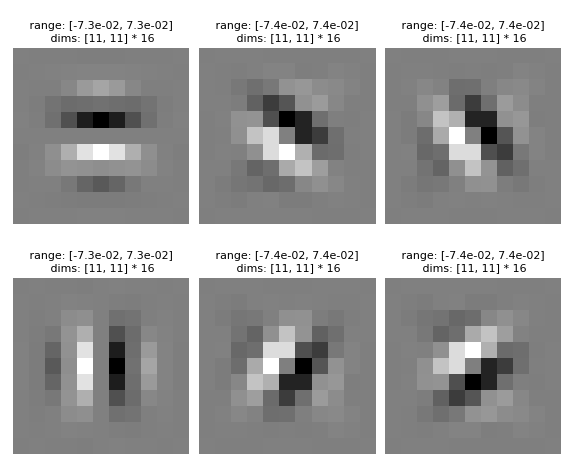

In [18]:
# Choose a filter set (options are 'sp0_filters', 'sp1_filters', 'sp3_filters', 'sp5_filters'):
filters = pt.steerable_filters('sp5_filters')
fsz = int(np.round(np.sqrt(filters['bfilts'].shape[0])))

fsz = np.array([fsz, fsz])
nfilts = filters['bfilts'].shape[1]
nrows = int(np.floor(np.sqrt(nfilts)))

import scipy.signal as sps
# Look at the oriented bandpass filters:
filtList = []
for f in range(nfilts):
    filtList.append(sps.convolve2d(filters['bfilts'][:,f].reshape(fsz), filters['lo0filt']))

pt.imshow(filtList, zoom= 16, col_wrap= 3);

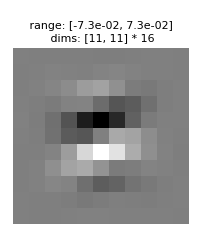

In [19]:
# Try "steering" to a new orientation (new_ori in degrees):
new_ori = -12

pt.imshow( sps.convolve2d( pt.pyramids.steer(filters['bfilts'],
                                      new_ori * np.pi/180).reshape(fsz),
                           filters['lo0filt']), 'auto', 16);

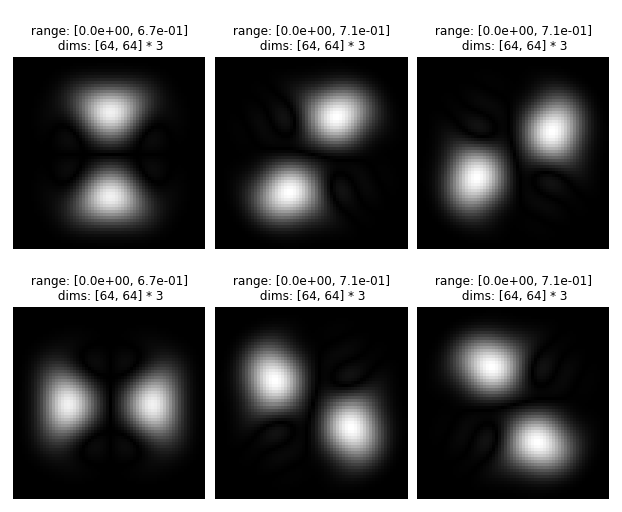

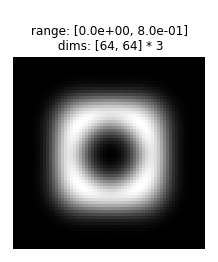

In [20]:
# Look at Fourier transform magnitudes:
lo0filt = filters['lo0filt']
bfilts = filters['bfilts']
lo0 = np.fft.fftshift(np.abs(np.fft.fft2(filters['lo0filt'],(64,64))))
fsum = np.zeros(lo0.shape)
imgList = []
for f in range(bfilts.shape[1]):
    flt = bfilts[:,f].reshape(fsz)
    freq = lo0 * np.fft.fftshift(np.abs(np.fft.fft2(flt,(64,64))))
    fsum += freq**2
    imgList.append(freq)

pt.imshow(imgList, vrange='auto', zoom=3, col_wrap= 3)

# The filters sum to a smooth annular ring:
pt.imshow(fsum, 'auto', 3);

In [21]:
# Looking again at the frequency domain picture

In [22]:
sz = 256
pyr = pt.pyramids.SteerablePyramidFreq(np.zeros((sz,sz)))

In [23]:
### Put an  impulse into the middle of each band:
for k, v in pyr.pyr_size.items():
    mid = (v[0]//2, v[1]//2)
#     print(lev, mid)
    pyr.pyr_coeffs[k][mid] = 1

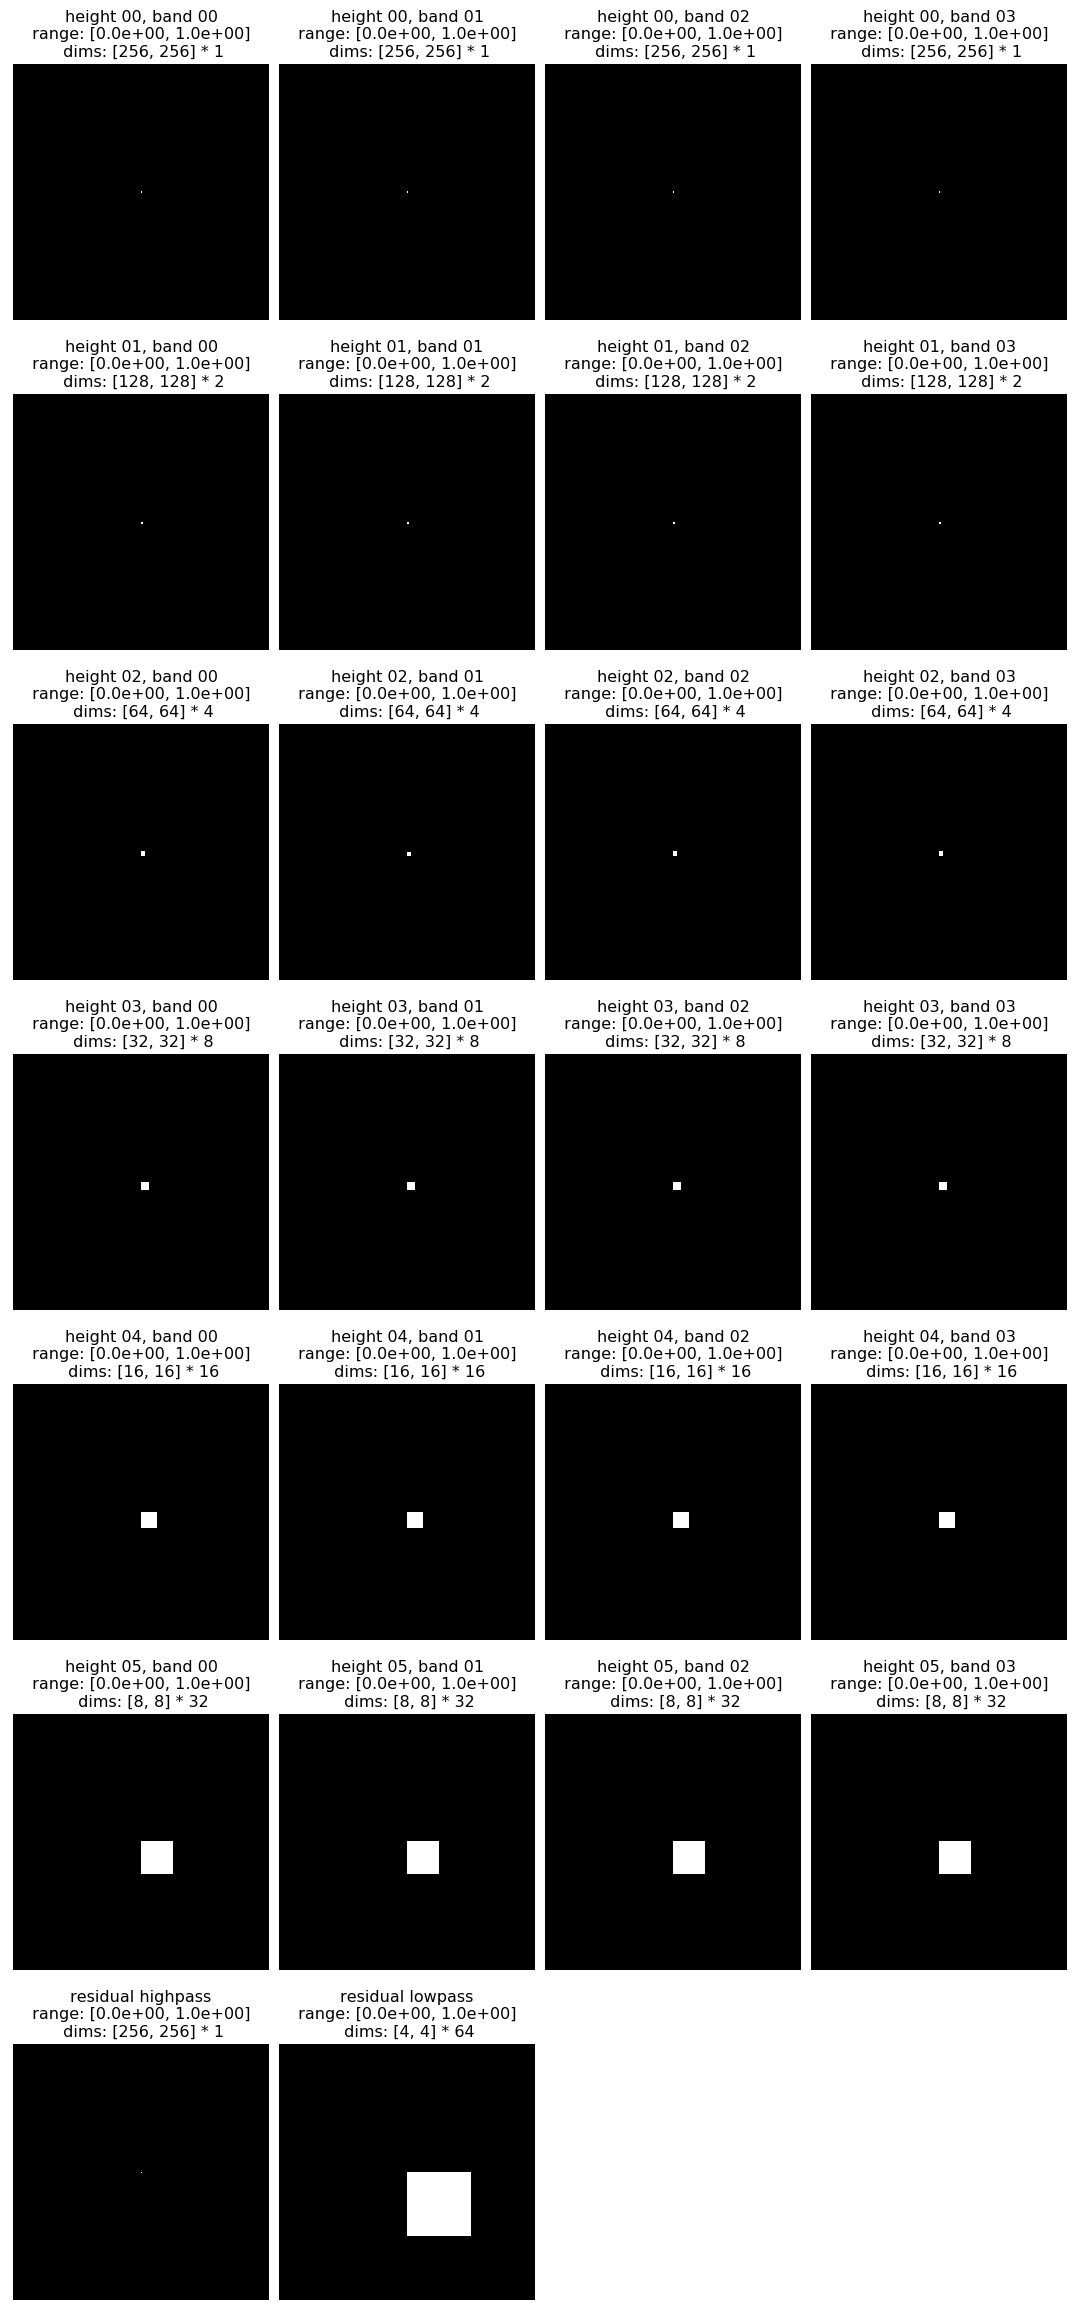

In [24]:
pt.pyrshow(pyr, vrange='indep1');

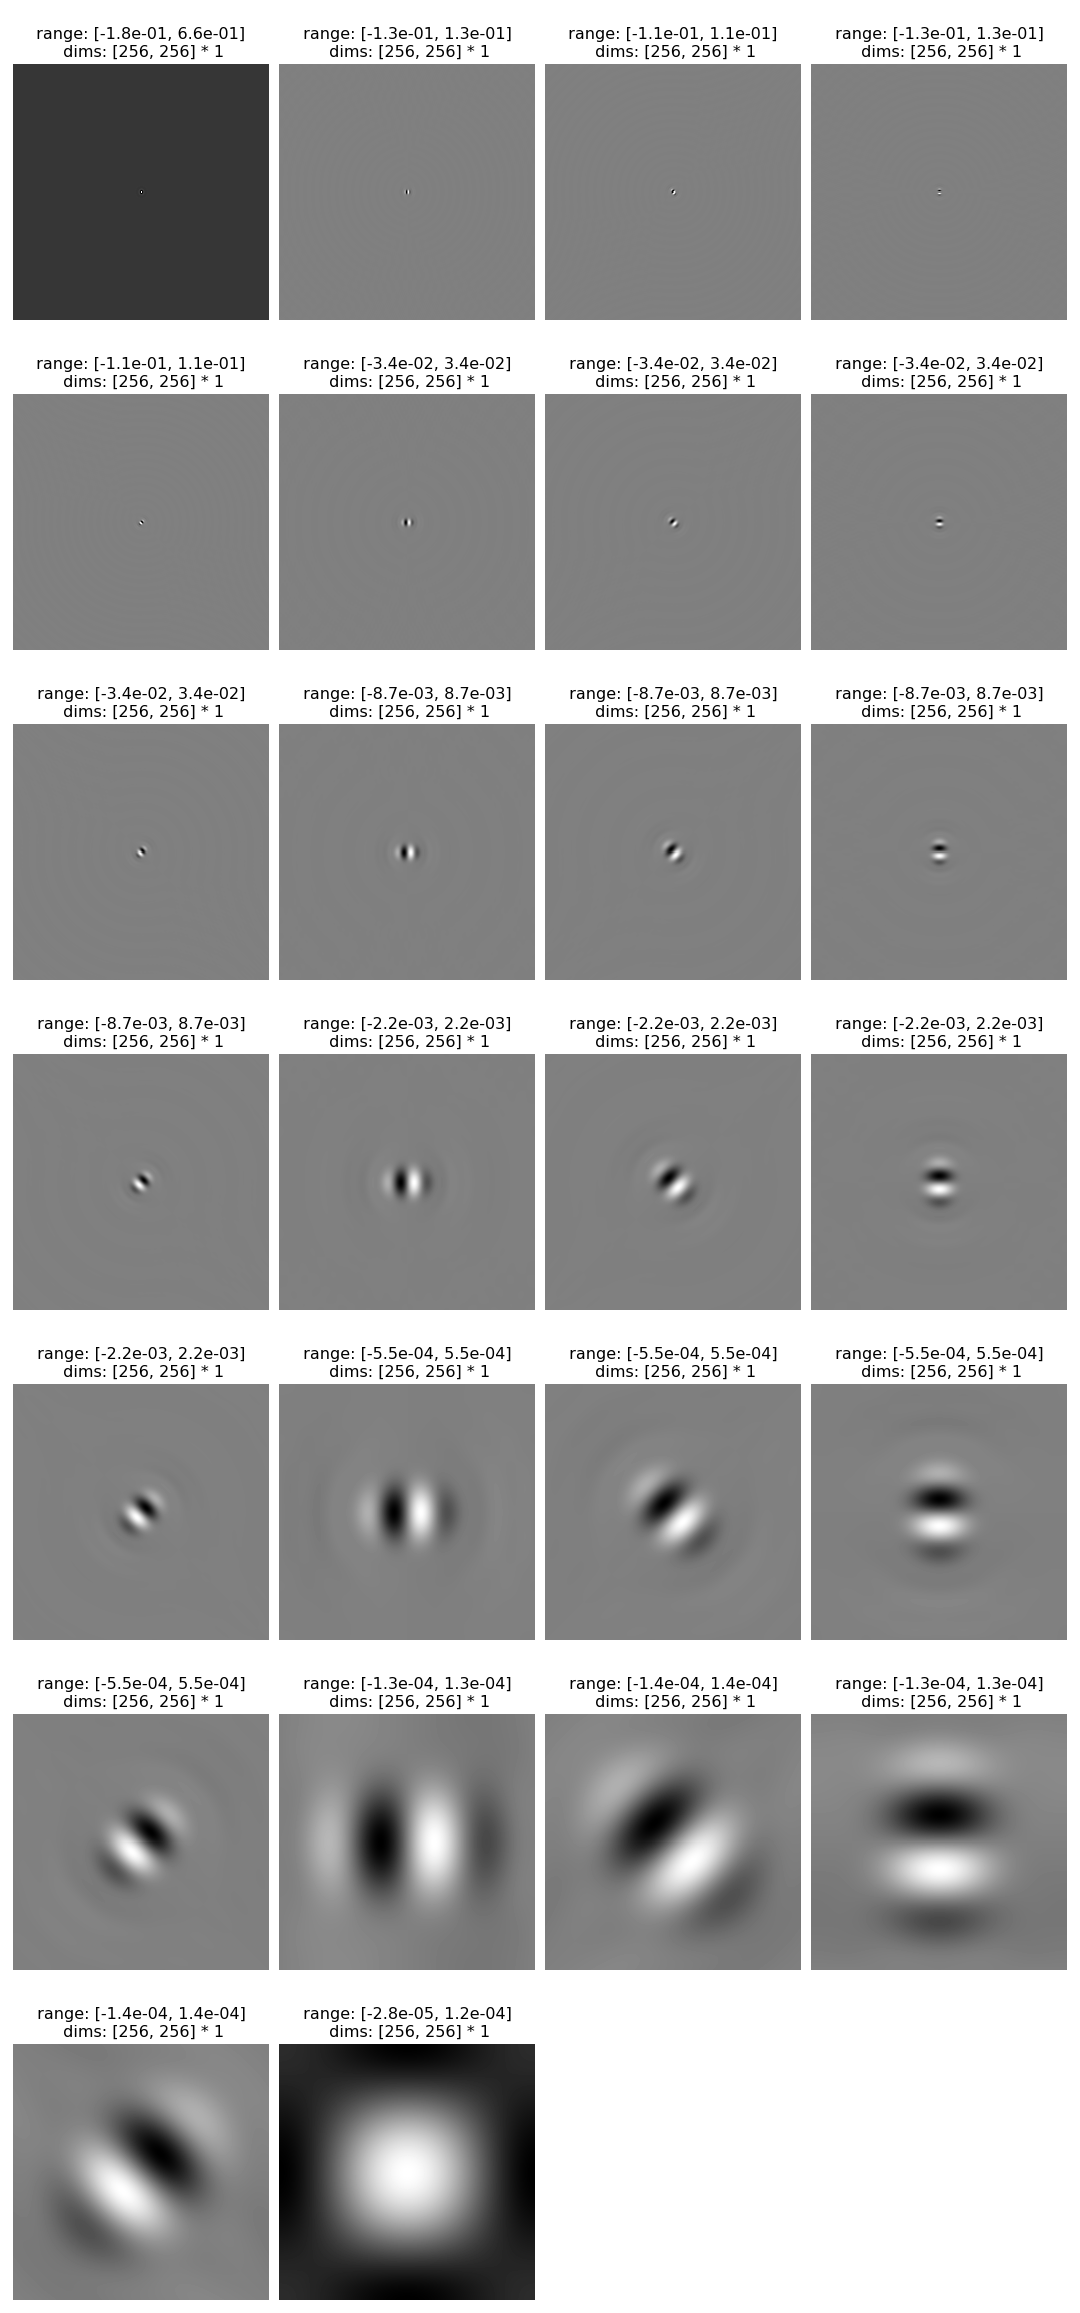

In [25]:
# And take a look at the reconstruction of each band:
reconList = []
for k in pyr.pyr_coeffs.keys():
    if isinstance(k, tuple):
        reconList.append(pyr.recon_pyr(k[0], k[1]))
    else:
        reconList.append(pyr.recon_pyr(k))

pt.imshow(reconList, col_wrap=pyr.num_orientations);

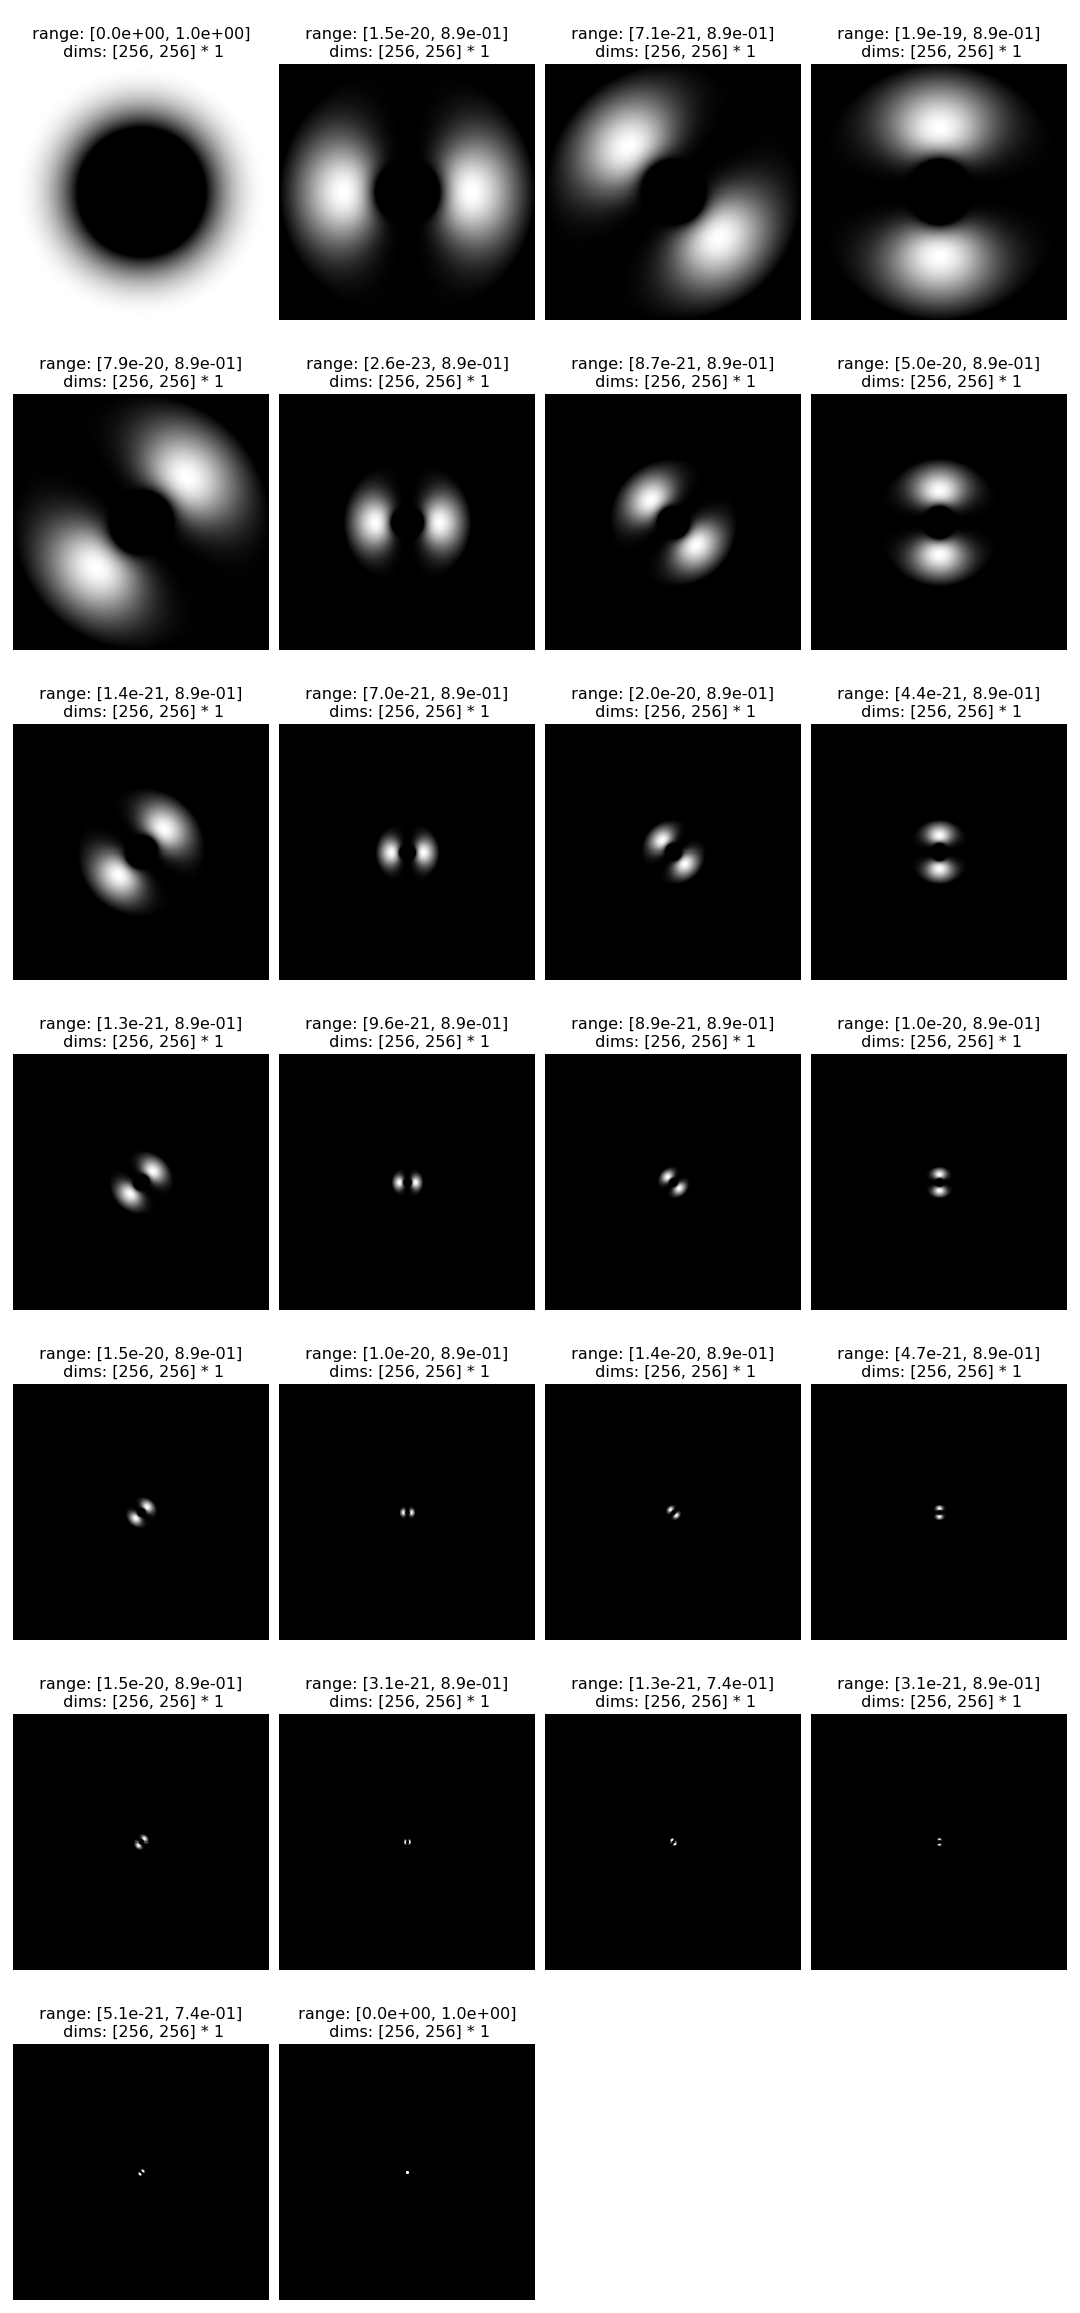

In [26]:
freq = 2 * np.pi * np.array(range(-sz//2,(sz//2)))/sz
imgList = []
for k in pyr.pyr_coeffs.keys():
    if isinstance(k, tuple):
        basisFn = pyr.recon_pyr(k[0], k[1])
    else:
        basisFn = pyr.recon_pyr(k)
    basisFmag = np.fft.fftshift(np.abs(np.fft.fft2(basisFn, (sz,sz))))
    imgList.append(basisFmag)

pt.imshow(imgList, col_wrap=pyr.num_orientations);

In [27]:
# Steering the activations of a pyramid

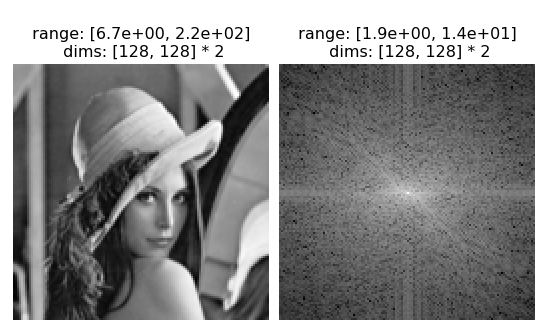

In [28]:
im = plt.imread('../DATA/lenna-256x256.tif').astype(float)

binom5 = pt.binomial_filter(5)
lo_filt = binom5*binom5.T
im = pt.corrDn(im, np.flipud(np.fliplr(lo_filt)), 'reflect1', step=[2, 2])

imgSize = im.shape[0]

sp = np.fft.fftshift(np.fft.fft2(im))
logfourieramplitude = np.log(np.abs(sp))
pt.imshow([im, logfourieramplitude], vrange='indep1', zoom=2);

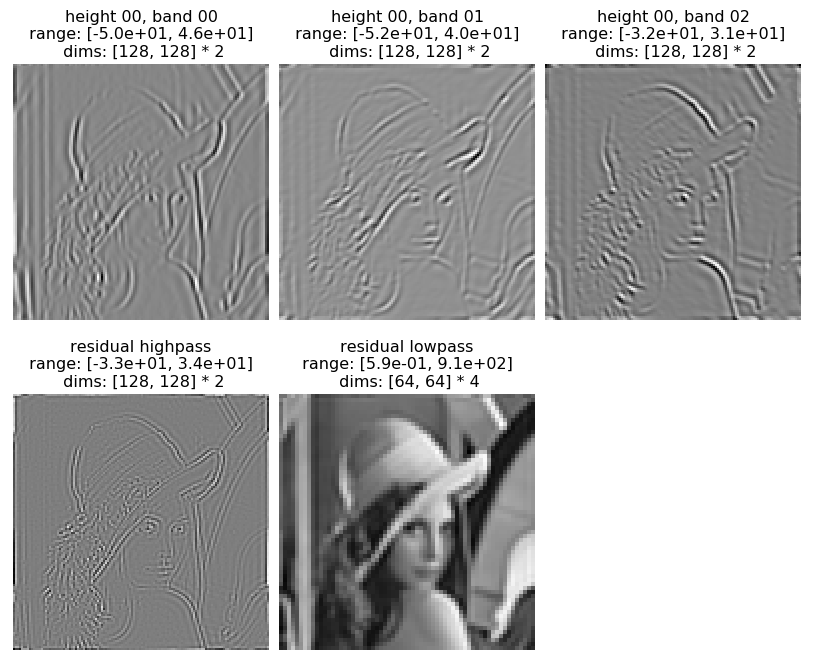

In [29]:
nOri = 3
pyr = pt.pyramids.SteerablePyramidFreq(im, height=1, num_orientations=nOri)

pt.pyrshow(pyr, zoom=2);

In [30]:
nOri = 5
even_phase = False

pyr = pt.pyramids.SteerablePyramidFreq(im, height=1, num_orientations=nOri)

b = [pyr.pyr_coeffs[(0, i)] for i in range(nOri)]
B = np.vstack([b[i].flatten() for i in range(nOri)]).T

nSteeredOri = 100

steering_vectors = []
steered_activations = []
for i in np.linspace(-180, 180, nSteeredOri):
    bi, vi = pt.pyramids.steer(B, angle = i * np.pi / 180, return_weights=True, even_phase=even_phase)
    steering_vectors.append(vi)
    bi = bi.reshape((imgSize,imgSize))
    steered_activations.append(bi)

steering_vectors = np.array(steering_vectors).T
steered_activations = np.stack(steered_activations, axis=0)

steered_activations.shape

(100, 128, 128)

In [31]:
pt.animshow(steered_activations, zoom=2)

In [32]:
# in the frequency domain

In [33]:
steeredim_dftampl = np.zeros_like(steered_activations)
for i in range(steered_activations.shape[0]):
    steeredim_dftampl[i] = np.fft.fftshift(np.abs(np.fft.fft2((steered_activations[i]),s=(imgSize, imgSize))))

In [34]:
pt.animshow(steeredim_dftampl, zoom=2)

In [35]:
# the steering weighting vectors

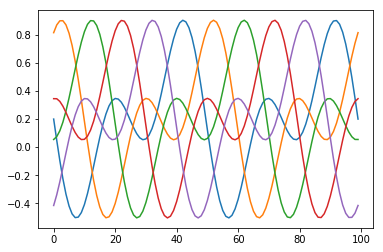

In [36]:
plt.figure()
for i in range(nOri):
    plt.plot(steering_vectors[i,:])
plt.show()

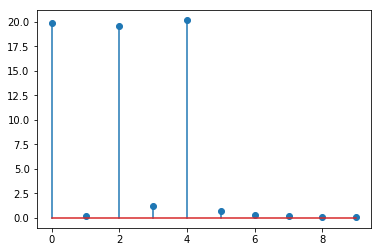

In [37]:
# expected harmonics (up to sapling error)
i = np.random.choice(nOri)
sp = np.fft.fftshift(np.fft.fft(steering_vectors[i,:]))
plt.stem(np.abs(sp)[sp.shape[0] // 2 : sp.shape[0] // 2 + nOri * 2])
plt.show()